In [3]:
import pandas as pd
import xarray as xr
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

# Open the Files

In [14]:
min_row = 21
min_col = 5
max_row = 25
max_col = 8

file_names = [f"r_{row:02}_c_{col:02}" for row in range(min_row, max_row+1) for col in range(min_col, max_col+1)]

print(len(file_names))

20


In [3]:
path = '/Volumes/Seagate/CHANGES/data_repository/CHL/Interpolated_Data/Combined/'

# Add the path to the file names
file_paths = [f"{path}{file}_combined.nc" for file in file_names]

# Get the list of files that exist in the directory
existing_files = [file for file in file_paths if glob.glob(file)]
print(len(existing_files))

20


# Swap coordinates
Then store it. 

Only need to do this once. The code will skip existing files. 

Please keep the transposed files in a seperate folder from the other netCDFs. 

In [21]:
output_path = '/Volumes/Seagate/CHANGES/data_repository/CHL/Interpolated_Data/Transposed'
transposed_directory = output_path

# Create the output path if it does not exist
os.makedirs(output_path, exist_ok=True)

print(len(existing_files), "files to process")

for file in existing_files:
    print("Processing file {:d} of {:d}".format(existing_files.index(file)+1, len(existing_files)), end='\r')

    base_name = os.path.basename(file)
    output_file = os.path.join(output_path, base_name)

    # If the output file already exists, skip it
    if os.path.exists(output_file):
        print("Output file {:s} already exists, skipping".format(base_name))
        continue

    ds = xr.open_dataset(file)

    # Get the chla data and swap the x and y dimensions
    chla_data = ds.chla.values
    swapped_data = chla_data.swapaxes(1, 2)

    # Create a new DataArray with the swapped data and the original coordinates
    swapped_da = xr.DataArray(swapped_data, coords=ds.chla.coords, dims=ds.chla.dims)
    swapped_ds = swapped_da.to_dataset(name='chla')

    # Save the swapped dataset to a new file
    swapped_ds.to_netcdf(output_file)

    ds.close()
    swapped_ds.close()

20 files to process


# Load the Transposed Files

In [14]:
# glob all the files in the transposed directory
transposed_directory = '/Volumes/Seagate/CHANGES/data_repository/CHL/Interpolated_Data/Transposed'
transposed_files = glob.glob(f"{transposed_directory}/*.nc")
transposed_files.sort()
print("{:d} .nc files in {:s}".format(len(transposed_files), transposed_directory))

20 .nc files in /Volumes/Seagate/CHANGES/data_repository/CHL/Interpolated_Data/Transposed


In [15]:
# Open all the transposed files and combine them into a single dataset by coordinates
ds = xr.open_mfdataset(transposed_files, combine='by_coords')

In [6]:
# Convert the 'time' coordinate to datetime and store in a new column
ds['datetime'] = pd.to_datetime(ds['time'].values, format='%Y%m%d')
ds

<xarray.Dataset>
Dimensions:   (x: 200, y: 250, time: 9138, datetime: 9138)
Coordinates:
  * x         (x) int64 -402475 -401475 -400475 ... -205475 -204475 -203475
  * y         (y) int64 -2333975 -2332975 -2331975 ... -2085975 -2084975
  * time      (time) int64 19980101 19980102 19980103 ... 20230130 20230131
  * datetime  (datetime) datetime64[ns] 1998-01-01 1998-01-02 ... 2023-01-31
Data variables:
    chla      (time, x, y) float64 dask.array<chunksize=(9138, 50, 50), meta=np.ndarray>

In [8]:
import os
output_folder = "/Volumes/Seagate/CHANGES/data_repository/CHL/Interpolated_Data/Transposed/annualmeans"
os.makedirs(output_folder, exist_ok=True)

# Extract the 'year' part of the 'datetime' coordinate
ds['year'] = ds['datetime'].dt.year

# Group the data by 'year'
grouped = ds.groupby('year')

for year, group in grouped:
    print("Processing year {:d}".format(year), end='\r')

    # Calculate the mean of the group along the 'time' dimension
    year_mean = group.mean(dim='time')

    # Save the mean data to a new file
    year_mean.to_netcdf(f"{output_folder}/mean_chla_{year}.nc")

    year_mean.close()

In [1]:
import pandas as pd

# output_folder = "/Volumes/Seagate/CHANGES/data_repository/CHL/Interpolated_Data/Transposed/annual_data_128"
output_folder = "/Volumes/Seagate/CHANGES/data_repository/CHL/Interpolated_Data/Transposed/august_data_128"
os.makedirs(output_folder, exist_ok=True)

# Convert the 'time' coordinate to datetime format
ds['time'] = pd.to_datetime(ds['time'].values, format='%Y%m%d')

# Loop through the years 1998-2023
for year in range(1998, 2024):
    print("Processing year {:d}".format(year), end='\r')

    # Subset the dataset to the dates for the current year
    # year_data = ds.sel(time=slice(pd.to_datetime(str(year)), pd.to_datetime(str(year+1))))
    year_data = ds.sel(time=slice(pd.to_datetime(f"{year}-08-01"), pd.to_datetime(f"{year}-08-31")))

    # Save the subset data to a new file
    year_data.to_netcdf(f"{output_folder}/chla_aug_{year}.nc")

    year_data.close()

In [13]:
import pandas as pd

output_folder = "/Volumes/Seagate/CHANGES/data_repository/CHL/Interpolated_Data/Transposed/annual_data"
os.makedirs(output_folder, exist_ok=True)

# Loop through the years 1998-2023
for year in range(1998, 2002):
    print("Processing year {:d}".format(year), end='\r')

    # Subset the dataset to the dates for the current year
    year_data = ds.sel(datetime=slice(pd.to_datetime(str(year)), pd.to_datetime(str(year+1))))

    print(year_data)

    # Save the mean data to a new file
    try:
        year_data.to_netcdf(f"{output_folder}/chla_{year}.nc")
    except Exception as e:
        print(f"Failed to save data for year {year}: {e}")

    year_data.close()

<xarray.Dataset>1998
Dimensions:   (x: 200, y: 250, datetime: 361)
Coordinates:
  * x         (x) int64 -402475 -401475 -400475 ... -205475 -204475 -203475
  * y         (y) int64 -2333975 -2332975 -2331975 ... -2085975 -2084975
  * datetime  (datetime) datetime64[ns] 1998-01-01 1998-01-02 ... 1999-01-01
Data variables:
    chla      (x, y) float64 1.055 0.9984 1.008 1.02 1.008 ... nan nan nan nan
    year      (datetime) int64 1998 1998 1998 1998 1998 ... 1998 1998 1998 1999
<xarray.Dataset>1999
Dimensions:   (x: 200, y: 250, datetime: 1)
Coordinates:
  * x         (x) int64 -402475 -401475 -400475 ... -205475 -204475 -203475
  * y         (y) int64 -2333975 -2332975 -2331975 ... -2085975 -2084975
  * datetime  (datetime) datetime64[ns] 1999-01-01
Data variables:
    chla      (x, y) float64 1.055 0.9984 1.008 1.02 1.008 ... nan nan nan nan
    year      (datetime) int64 1999
<xarray.Dataset>2000
Dimensions:   (x: 200, y: 250, datetime: 0)
Coordinates:
  * x         (x) int64 -402475 

In [11]:
# glob the files in "/Volumes/Seagate/CHANGES/data_repository/CHL/Interpolated_Data/Transposed/annualmeans2"
annual_means_folder = "/Volumes/Seagate/CHANGES/data_repository/CHL/Interpolated_Data/Transposed/annualmeans2"
annual_means_files = glob.glob(f"{annual_means_folder}/*.nc")
annual_means_files.sort()
# open annual_means_files[0]
ds = xr.open_dataset(annual_means_files[0])
ds


<xarray.Dataset>
Dimensions:   (x: 200, y: 250, datetime: 361)
Coordinates:
  * x         (x) int64 -402475 -401475 -400475 ... -205475 -204475 -203475
  * y         (y) int64 -2333975 -2332975 -2331975 ... -2085975 -2084975
  * datetime  (datetime) datetime64[ns] 1998-01-01 1998-01-02 ... 1999-01-01
Data variables:
    chla      (x, y) float64 ...
    year      (datetime) int64 ...

In [ ]:
import pandas as pd

output_folder = "/Volumes/Seagate/CHANGES/data_repository/CHL/Interpolated_Data/Transposed/augustmeans"
os.makedirs(output_folder, exist_ok=True)

# Loop through the years 1998-2023
for year in range(1998, 2024):
    print("Processing year {:d}".format(year), end='\r')

    # Subset the dataset to the dates for August of the current year
    year_data = ds.sel(datetime=slice(pd.to_datetime(f"{year}-08-01"), pd.to_datetime(f"{year}-08-31")))

    # Calculate the mean of the subset along the 'time' dimension
    year_mean = year_data.mean(dim='time')

    # Save the mean data to a new file
    year_mean.to_netcdf(f"{output_folder}/mean_chla_{year}_august.nc")

    year_mean.close()

In [7]:
# Get the mean of the dataset along the time dimension
ds_mean = ds.mean(dim='time')

In [8]:
# Get the chla data as a 2D numpy array, flip it along the x-axis, and rotate 90 degrees clockwise
chla_data = np.fliplr(ds_mean.chla.values)
rotated_data = np.rot90(chla_data, 1)

In [9]:
# Convert the 'time' coordinate to datetime and store in a new column
ds['datetime'] = pd.to_datetime(ds['time'].values, format='%Y%m%d')

In [12]:
# write ds to ../data_files/pre_2003.nc
ds.to_netcdf('../data_files/pre_2003.nc')

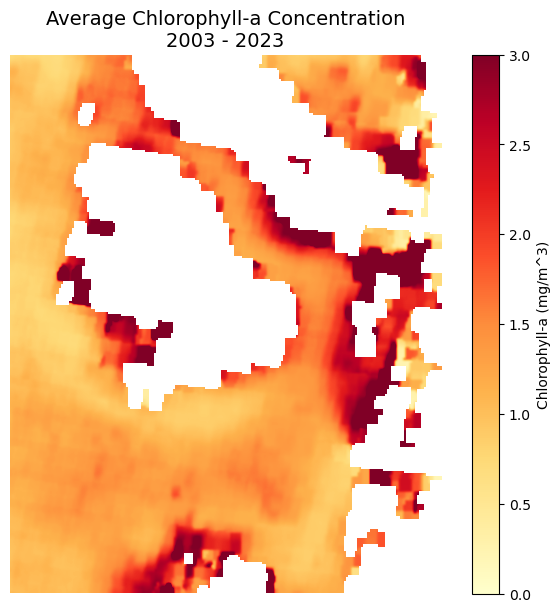

In [11]:
# Get the years from the datetime column (for title)
years = ds.datetime.dt.year.values
years = np.unique(years)
years.sort()

# Create a new figure
plt.figure(figsize=(8, 7))

# Plot a heatmap of the mean chla with bicubic interpolation
plt.imshow(rotated_data, origin='lower', cmap='YlOrRd', vmin=0, vmax=3, interpolation='bicubic')

plt.title('Average Chlorophyll-a Concentration\n{:d} - {:d}'.format(years[0], years[-1]), fontsize=14)

# Hide the axes and ticks
plt.axis('off')

# Add a colorbar
plt.colorbar(label='Chlorophyll-a (mg/m^3)')

# Show & close the plot
plt.show()
plt.close('all')

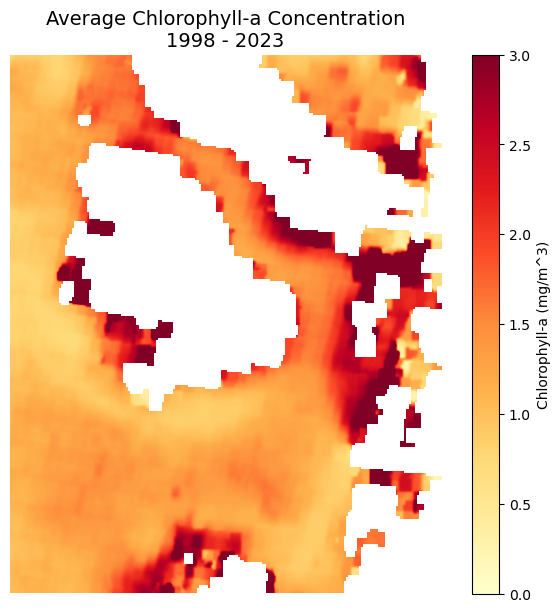

In [68]:
# Get the years from the datetime column (for title)
years = ds.datetime.dt.year.values
years = np.unique(years)
years.sort()

# Create a new figure
plt.figure(figsize=(8, 7))

# Plot a heatmap of the mean chla with bicubic interpolation
plt.imshow(rotated_data, origin='lower', cmap='YlOrRd', vmin=0, vmax=3, interpolation='bicubic')

plt.title('Average Chlorophyll-a Concentration\n{:d} - {:d}'.format(years[0], years[-1]), fontsize=14)

# Hide the axes and ticks
plt.axis('off')

# Add a colorbar
plt.colorbar(label='Chlorophyll-a (mg/m^3)')

# Show & close the plot
plt.show()
plt.close('all')

In [57]:
# Get a heatmap/array of the standard deviation of the chla through time
ds_std = ds.std(dim='time')
std_data = np.fliplr(ds_std.chla.values)
rotated_std = np.rot90(std_data, 1)

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


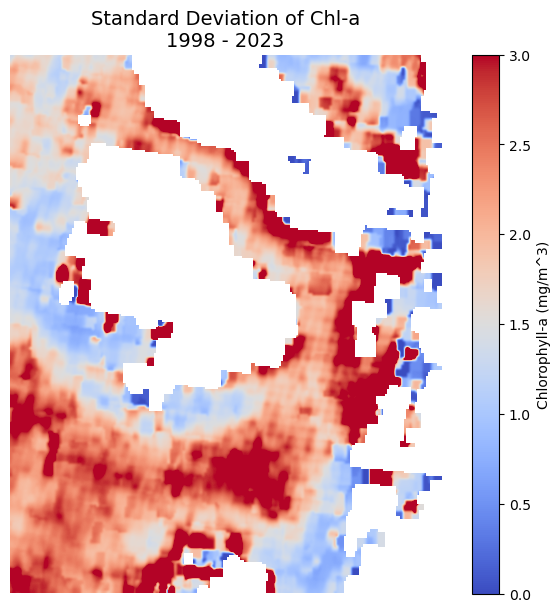

In [71]:
# Get the years from the datetime column (for title)
years = ds.datetime.dt.year.values
years = np.unique(years)
years.sort()

# Create a new figure
plt.figure(figsize=(8, 7))

# Plot a heatmap of the mean chla with bicubic interpolation
plt.imshow(rotated_std, origin='lower', cmap='coolwarm', vmin=0, vmax=3, interpolation='bicubic')

plt.title('Standard Deviation of Chl-a\n{:d} - {:d}'.format(years[0], years[-1]), fontsize=14)

# Hide the axes and ticks
plt.axis('off')

# Add a colorbar
plt.colorbar(label='Chlorophyll-a (mg/m^3)')

# Show & close the plot
plt.show()
plt.close('all')

In [66]:
# # Compare 4 different interpolations

# # Create a new figure
# fig, axs = plt.subplots(2, 2, figsize=(16, 14))

# # List of interpolations
# interpolations = ['none', 'bilinear', 'gaussian', 'bicubic']

# # Plot a heatmap of the mean chla with different interpolations
# for i, ax in enumerate(axs.flat):
#     im = ax.imshow(rotated_std, origin='lower', cmap='coolwarm', vmin=0, vmax=3, interpolation=interpolations[i])
#     ax.set_title('Interpolation: {}'.format(interpolations[i]), fontsize=14)
#     ax.axis('off')

# # Add a colorbar
# fig.colorbar(im, ax=axs.ravel().tolist(), label='Chlorophyll-a (mg/m^3)')

# # Show & close the plot
# plt.show()
# plt.close('all')